In [2]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, roc_auc_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor, XGBClassifier
from xgboost import plot_importance
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## Выгрузка данных

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
'''1.Файл с данными результатов обследований на Ковид (описаны значимые поля):
IDX - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
gender - пол пациента
birth_dt - Дата рождения
dis_date - Дата начала заболевания (со слов пациента или дата обращения за анализом)
samples_type_id - вид биоматериала
get_date - дата взятия биоматериала
IgG, IgM - значения уровня иммуноглобулинов (для биоматериала Кровь)
Samples_result_id - значение Обнаружено/не обнаружено (для биоматериала Мазок)
Mu_type - тип медучреждения, где выполнялось взятие биоматериала
'''
df_covid = pd.read_csv('data_for_science_2020-07-27_w_mu_type.csv', sep=';')
print(f'df_covid shape: {df_covid.shape}')
df_covid.head()

df_covid shape: (1954524, 17)


,idx,pd_id,person_id,ds_id,gender,birth_dt,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type
0,0,1562717,1460618,1652919,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.18,0.55,NaN,Городская поликлиника
1,0,1562759,1460660,1653238,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-17,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника
2,1,1564183,1462084,1654584,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.20,0.18,NaN,Городская поликлиника
3,1,1563996,1461897,1654530,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-18,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника
4,2,1576768,1474472,1667726,Ж,1982-11-07,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.24,0.23,NaN,Городская поликлиника


In [5]:
print(f'df_covid shape: {df_covid.shape}, idx unique qty: {len(df_covid.idx.unique())}')

df_covid shape: (1954524, 17), idx unique qty: 892046


In [6]:
df_covid['samples_result_id'].unique()

array([nan, 'Не обнаружено', 'ОБНАРУЖЕНО', 'Подозрительный'], dtype=object)

### Добавим дополнительные признаки в таблицу df_covid

In [7]:
# В результатах диагностики есть NA - в случаях когда есть показатели крови IgM IgG, 
# создадим итоговый признак со статусом теста на ковид (уточнить референтное значение для IgM когда считаем ковид положительный)

df_covid['status'] = np.where(~df_covid['samples_result_id'].isna(), df_covid['samples_result_id'], 
                              np.where(df_covid['IgM'] > 0.05, 'ОБНАРУЖЕНО', 'Не обнаружено'))
# добавим признак положительного ковида для аккумулированного признака
df_covid['posit'] = np.where(df_covid['status'] == 'ОБНАРУЖЕНО', 1, 0)

# считаем кумулятивную сумму положит тестов на ковид к текущей дате предварительно отсортировав датасет по дате
df_covid['get_date_at'] = pd.to_datetime(df_covid['get_date_at'])
df_covid.sort_values(by=['idx', 'get_date_at'], inplace=True)
df_covid['agg_posit'] = df_covid.groupby(['idx'])['posit'].cumsum()
df_covid.head()

,idx,pd_id,person_id,ds_id,gender,birth_dt,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit
0,0,1562717,1460618,1652919,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.18,0.55,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1
1,0,1562759,1460660,1653238,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-17,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0,1
2,1,1564183,1462084,1654584,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.20,0.18,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1
3,1,1563996,1461897,1654530,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-18,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0,1
4,2,1576768,1474472,1667726,Ж,1982-11-07,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.24,0.23,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1


In [8]:
# для каждого пациента выведем признаки не зависящие от даты, это пол и дата рождения,
# по дате рождения создадим новый признак с возрастной категорией

stat_features = df_covid[['idx','gender', 'birth_dt']].drop_duplicates()
stat_features['birth_dt'] = pd.to_datetime(stat_features['birth_dt'])
stat_features['age'] = (datetime.date.today() - stat_features['birth_dt'].dt.date) // datetime.timedelta(days=365)
stat_features['age_group'] = pd.cut(stat_features['age'], bins=[0, 18, 30, 55, 70, 100], include_lowest=True, labels=['<18', '18-30', '30-55','55-70', '>70'])
stat_features.head()

,idx,gender,birth_dt,age,age_group
0,0,М,1995-11-26,26,18-30
2,1,Ж,1972-02-22,50,30-55
4,2,Ж,1982-11-07,39,30-55
6,3,Ж,1947-11-12,74,>70
8,4,Ж,1973-04-21,48,30-55


In [9]:
'''2. Файл с результатами КТ-исследований (train) и файл аналогичной структуры для валидации результатов (evaluate).
Необходимо проставить классы в таком же формате (КТ-0-4), в каком они указаны в исходном файле.
IDX - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
DATE - Дата исследования
KT_Result - Результат'''

df_train = pd.read_csv('data_for_science_KT_train.csv', sep=',')
df_test = pd.read_csv('data_for_science_KT_evaluate.csv', sep=',')
print(f'df_train shape: {df_train.shape}')
df_train.head()

df_train shape: (132289, 3)


,idx,DATE,KT_RESULT
0,301478,2020-04-17,КТ-1
1,18024,2020-04-17,КТ-0
2,191578,2020-04-17,КТ-1
3,215212,2020-04-18,КТ-1
4,689401,2020-04-18,КТ-2


In [10]:
# Файл аналогичной структуры для валидации результатов (evaluate)

df_test = pd.read_csv('data_for_science_KT_evaluate.csv', sep=',')
print(f'df_test shape: {df_test.shape}')
df_test.head()

df_test shape: (33080, 3)


,idx,DATE,KT_RESULT
0,644661,2020-04-17,NaN
1,292115,2020-04-18,NaN
2,556023,2020-04-18,NaN
3,233104,2020-04-18,NaN
4,90502,2020-04-18,NaN


In [12]:
print(f'train_size: {df_train.shape}, test_size: {df_test.shape}')

train_size: (132289, 3), test_size: (33080, 3)


In [13]:
'''3. Файл с датами смерти
IDX - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
DATE - Дата смерти
'''
df_death = pd.read_csv('data_for_science_death_2020-07-27.csv', sep=';')
df_death.head()

,idx,DEATH_DATE
0,560895,2020-04-20
1,550632,2020-04-20
2,551890,2020-04-20
3,551301,2020-04-20
4,567839,2020-04-20


In [14]:
'''4. Файл с результатами лабораторных исследований
idx - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
ISSL_NAME - Наименование исследования (в одном исследовании может быть несколько тестов)
TEST_NAME - Наименование теста (показателя)
TEST_VAL - Результат теста (в формате текста для качественных результатов или в виде ЗНАЧЕНИЕ[_]ЕДИНИЦА ИЗМЕРЕНИЯ для количественных результатов)
TEST_TIME - Дата результата
'''

df_lls = pd.read_csv('data_for_science_LIs_2020-07-27.csv', sep=';')
df_lls.head()

,idx,ISSL_NAME,TEST_NAME,TEST_VAL,TEST_TIME
0,911641,Исследование вагинального отделяемого,Эритроциты,Не обнаружены_в п/зр,2020-04-20 00:00
1,1258130,Исследование вагинального отделяемого,Эпителий поверхностный,Значительное количество,2020-04-20 00:00
2,1258130,Исследование вагинального отделяемого,'Ключевая клетка',Не обнаружены,2020-04-20 00:00
3,1258130,Исследование вагинального отделяемого,Лейкоциты,30-60 в п/зр_в п/зр,2020-04-20 00:00
4,911641,Исследование вагинального отделяемого,'Ключевая клетка',Не обнаружены,2020-04-20 00:00


In [15]:
df_lls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5931169 entries, 0 to 5931168
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   idx        int64 
 1   ISSL_NAME  object
 2   TEST_NAME  object
 3   TEST_VAL   object
 4   TEST_TIME  object
dtypes: int64(1), object(4)
memory usage: 226.3+ MB


In [16]:
'''5. Файл-опросник
idx - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
Остальные колонки - Название колонки - вопрос, значения в колонке - ответ
'''

df_quest = pd.read_csv('data_for_science_questions_2020-07-27.csv', sep=';')
df_quest.head()

,idx,pd_id,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель
0,206897,2414095,Нет,Нет,Да,Нет,NaN,NaN,NaN,NaN,NaN
1,206842,2419546,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN
2,206910,2418140,Да,Да,Да,Нет,NaN,NaN,NaN,NaN,NaN
3,206945,2420934,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN
4,206969,2420568,Нет,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN


In [17]:
'''6. Файл с диагнозами (не использовался)
IDX - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
DATE - Дата диагноза
DIAGNOSIS - Код диагноза'''

df_diagnoses = pd.read_csv('data_for_science_diagnoses_2020-07-27.csv', sep=';')
df_diagnoses.head()

,idx,DATE,DIAGNOSIS
0,870886,2019-04-20,J01.9
1,337455,2019-04-20,J30.1
2,368183,2019-04-20,J32.8
3,355037,2019-04-20,J00
4,926418,2019-04-20,J04.2


In [20]:
'''7. Файл с назначенными препаратами (не использовался)
IDX - анонимизированный идентификатор пациента. по нему файлы связаны между собой.
DATE - Дата диагноза
RECIPE - Назначенные препараты
'''

df_drugs = pd.read_csv('data_for_science_drugs_2020-07-27.csv', sep=';')
df_drugs.head()

,idx,DATE,RECIPE
0,598671,2020-04-20,Рецепт 00Д4510052223: Azithromycinum - Применя...
1,209779,2020-04-20,Рецепт 00Э4592249744: Levofloxacinum - Применя...
2,104603,2020-04-20,Рецепт 00Д4510053059: Amoxicillinum+Acidum Cla...
3,282717,2020-04-20,Рецепт 00Д4510053202: Azithromycinum - Применя...
4,596802,2020-04-20,Рецепт 00Д4510051283: Azithromycinum - Применя...


### Таким образом, имеем:

- каждая строка опроса соответствует номеру обращения в таблице df_covid
- данные к train и test будем подтягивать ближайшие прошлые обращения и опросник, аккумулированные данные по положительным тестам на ковид, а также диагноз и назначение препаратов, ближайшей прошедшей даты к дате КТ

In [21]:
# добавим к файлу с диагностикой ковид - опросник, соответствующий обращению (pd_id)

df_covid_quest = df_covid.merge(df_quest, on=('idx', 'pd_id'), how='left')
df_covid_quest.head()

,idx,pd_id,person_id,ds_id,gender,birth_dt,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель
0,0,1562717,1460618,1652919,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.18,0.55,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1562759,1460660,1653238,М,1995-11-26,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-17,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,1564183,1462084,1654584,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.20,0.18,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,1563996,1461897,1654530,Ж,1972-02-22,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-17,2020-05-18,2020-05-18,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,1576768,1474472,1667726,Ж,1982-11-07,Z11.5,Специальное скрининговое обследование с целью ...,2020-05-17,"Кровь, цельная (сыворотка)",2020-05-17,2020-05-17,2020-05-17,0.24,0.23,NaN,Городская поликлиника,ОБНАРУЖЕНО,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так сбора данных для train и test используем только данные из прошлого во избежание ликов и переобучения.Так как структура train и test выборок одинаковая, для удобства объединим train и test выборки для сбора полного датасета и перед итоговой предобработкой разделим данные снова 

In [22]:
df = df_train.append(df_test)
df.head()

,idx,DATE,KT_RESULT
0,301478,2020-04-17,КТ-1
1,18024,2020-04-17,КТ-0
2,191578,2020-04-17,КТ-1
3,215212,2020-04-18,КТ-1
4,689401,2020-04-18,КТ-2


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165369 entries, 0 to 33079
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   idx        165369 non-null  int64 
 1   DATE       165369 non-null  object
 2   KT_RESULT  132289 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


In [24]:
df.sort_values(by='DATE', inplace=True)
df = df.reset_index().drop('index', axis=1)
df.head()

,idx,DATE,KT_RESULT
0,301478,2020-04-17,КТ-1
1,327426,2020-04-17,КТ-0
2,644661,2020-04-17,NaN
3,435395,2020-04-17,NaN
4,365812,2020-04-17,NaN


In [25]:
df_lls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5931169 entries, 0 to 5931168
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   idx        int64 
 1   ISSL_NAME  object
 2   TEST_NAME  object
 3   TEST_VAL   object
 4   TEST_TIME  object
dtypes: int64(1), object(4)
memory usage: 226.3+ MB


In [26]:
# все даты в файлах имеют type object, для корректной работы с датами преобразуем их в тип datetime

df['DATE'] = pd.to_datetime(df['DATE'])
df_diagnoses['DATE'] = pd.to_datetime(df_diagnoses['DATE'])
df_drugs['DATE'] = pd.to_datetime(df_drugs['DATE'])
df_lls['dt'] = pd.to_datetime(df_lls['TEST_TIME'])

In [27]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152087 entries, 0 to 152086
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   idx     152087 non-null  int64         
 1   DATE    152087 non-null  datetime64[ns]
 2   RECIPE  152087 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 3.5+ MB


In [28]:
df_covid_quest.sort_values(by='get_date_at', inplace=True)

In [29]:
# добавим данные диагностики по ближайшейпредыдущей дате
df = pd.merge_asof(df, df_diagnoses, left_on='DATE', right_on='DATE', by='idx', direction='backward')

# добавим данные диагностики по ближайшейпредыдущей дате
#df = pd.merge_asof(df, df_lls, left_on='DATE', right_on='TEST_TIME', by='idx', direction='backward')

# добавим данные диагностики по ближайшейпредыдущей дате
df = pd.merge_asof(df, df_drugs, left_on='DATE', right_on='DATE', by='idx', direction='backward')
df = pd.merge_asof(df, df_covid_quest, left_on='DATE', right_on='get_date_at', by='idx', direction='backward')

# так как не ко всем датам КТ есть предшествующая диагностика, поля gender birth_dt и возраст содержат NaN,
# добавим их из полученных ранее по каждому пациенту

df = df.drop(['gender', 'birth_dt'],axis=1)
df = df.merge(stat_features, on='idx')
df.head()

,idx,DATE,KT_RESULT,DIAGNOSIS,RECIPE,pd_id,person_id,ds_id,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель,gender,birth_dt,age,age_group
0,301478,2020-04-17,КТ-1,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1970-09-02,51,30-55
1,301478,2020-06-05,КТ-2,J12.9,NaN,2848114.0,2751334.0,3003267.0,J12.9,Вирусная пневмония неуточненная,2020-04-16,"Кровь, цельная (сыворотка)",2020-06-05,2020-06-06,2020-06-06,80.38,9.87,NaN,Городская поликлиника,ОБНАРУЖЕНО,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1970-09-02,51,30-55
2,327426,2020-04-17,КТ-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1953-01-09,69,55-70
3,644661,2020-04-17,NaN,J02.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1956-09-14,65,55-70
4,644661,2020-04-21,NaN,J02.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1956-09-14,65,55-70


In [30]:
# для добавления признака предыдущего КТ аксимальной тяжести (надо будет добавить еще период  - сколько дней назад было
# и просто предыдущий ближайший результат КТ + бинарный признак была ли до этого пневмония или нет)

df_kt = df[['idx', 'DATE', 'KT_RESULT']].rename(columns={'DATE':'DATE_before'})
df_kt['KT_num'] = np.where(df_kt['KT_RESULT'].isna(), -1, df_kt['KT_RESULT'].str[-1])
df_kt['KT_num'] = df_kt['KT_num'].astype('int')
df_kt['KT_max'] = df_kt.groupby(['idx'])['KT_num'].cummax()
df_kt.sort_values(by='DATE_before', inplace=True)
df_kt.head()

,idx,DATE_before,KT_RESULT,KT_num,KT_max
0,301478,2020-04-17,КТ-1,1,1
2,327426,2020-04-17,КТ-0,0,0
3,644661,2020-04-17,NaN,-1,-1
7,435395,2020-04-17,NaN,-1,-1
8,365812,2020-04-17,NaN,-1,-1


In [31]:
df.sort_values(by='DATE', inplace=True)
df['DATE_before'] = df['DATE'] - pd.Timedelta("1D")
df = pd.merge_asof(df, df_kt[['idx', 'DATE_before', 'KT_max']], on='DATE_before', by='idx', direction='backward')
df.head()

,idx,DATE,KT_RESULT,DIAGNOSIS,RECIPE,pd_id,person_id,ds_id,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель,gender,birth_dt,age,age_group,DATE_before,KT_max
0,301478,2020-04-17,КТ-1,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1970-09-02,51,30-55,2020-04-16,NaN
1,327426,2020-04-17,КТ-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1953-01-09,69,55-70,2020-04-16,NaN
2,644661,2020-04-17,NaN,J02.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1956-09-14,65,55-70,2020-04-16,NaN
3,435395,2020-04-17,NaN,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1965-08-28,56,55-70,2020-04-16,NaN
4,365812,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1955-06-18,66,55-70,2020-04-16,NaN


In [32]:
# полученный датасет снова разделим на train и test

df_train = df[~df.KT_RESULT.isna()]
df_test = df[df.KT_RESULT.isna()]
df_train.shape, df_test.shape

((132671, 37), (33177, 37))

### Посмотрим на распределение основных категориальных принаков

<AxesSubplot:xlabel='KT_max', ylabel='count'>

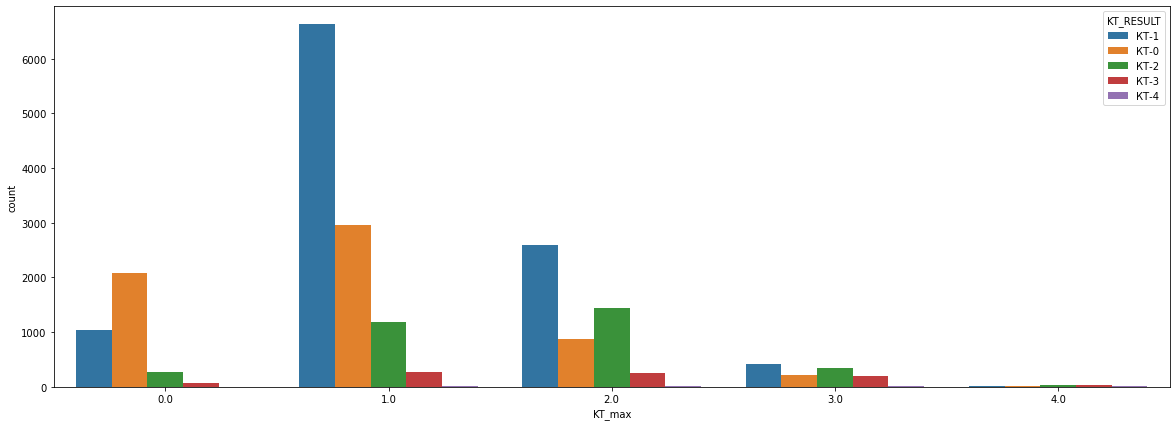

In [33]:
plt.figure(figsize=(20, 7))
sns.countplot(x='KT_max', data=df_train, hue='KT_RESULT')

<AxesSubplot:xlabel='gender', ylabel='count'>

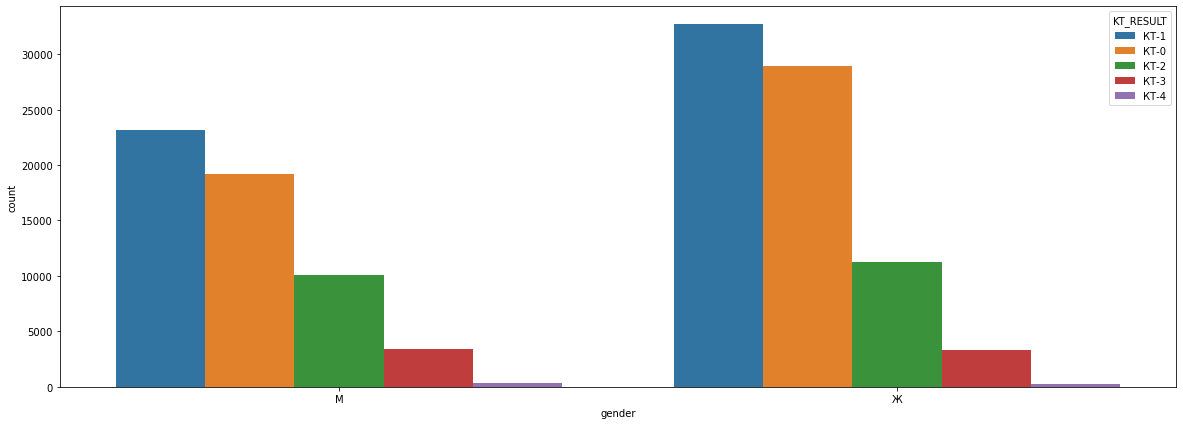

In [34]:
plt.figure(figsize=(20, 7))
sns.countplot(x='gender', data=df_train, hue='KT_RESULT')

<AxesSubplot:xlabel='age_group', ylabel='count'>

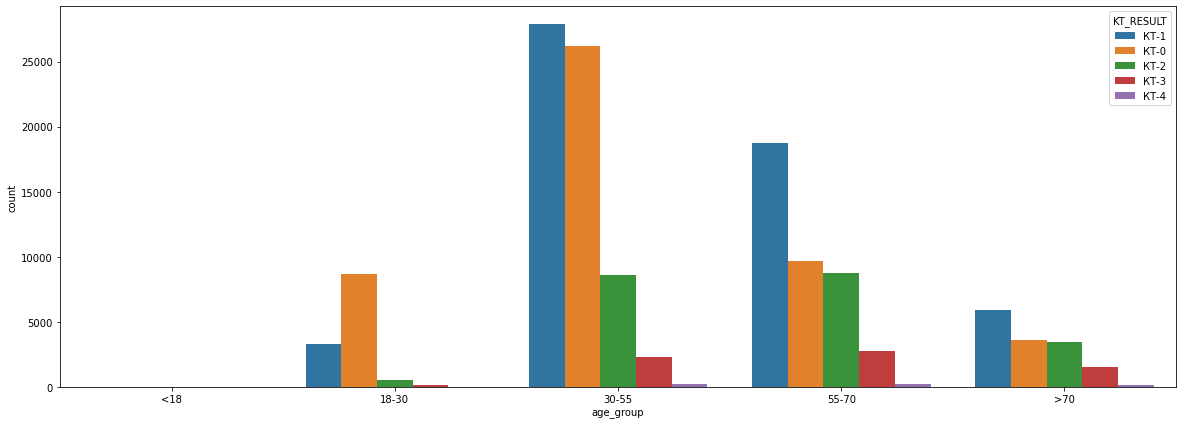

In [35]:
plt.figure(figsize=(20, 7))
sns.countplot(x='age_group', data=df_train, hue='KT_RESULT')

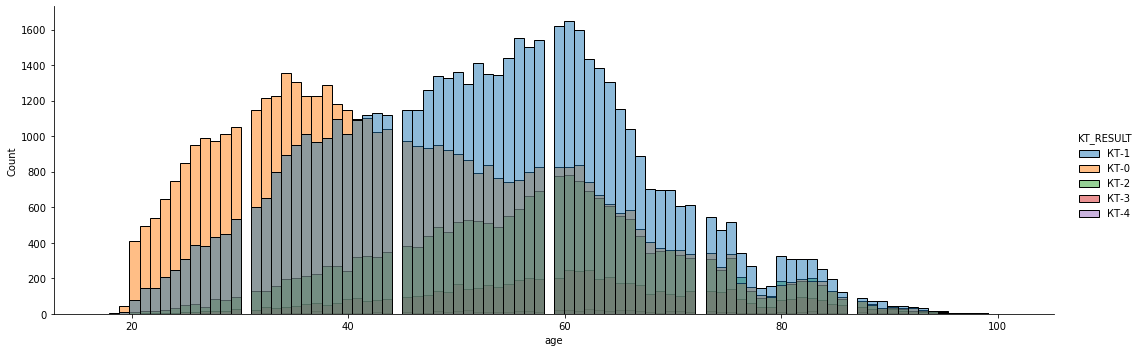

In [36]:
sns.displot(x='age', data=df_train, hue='KT_RESULT', bins=90, aspect=3/1)

<AxesSubplot:xlabel='agg_posit', ylabel='count'>

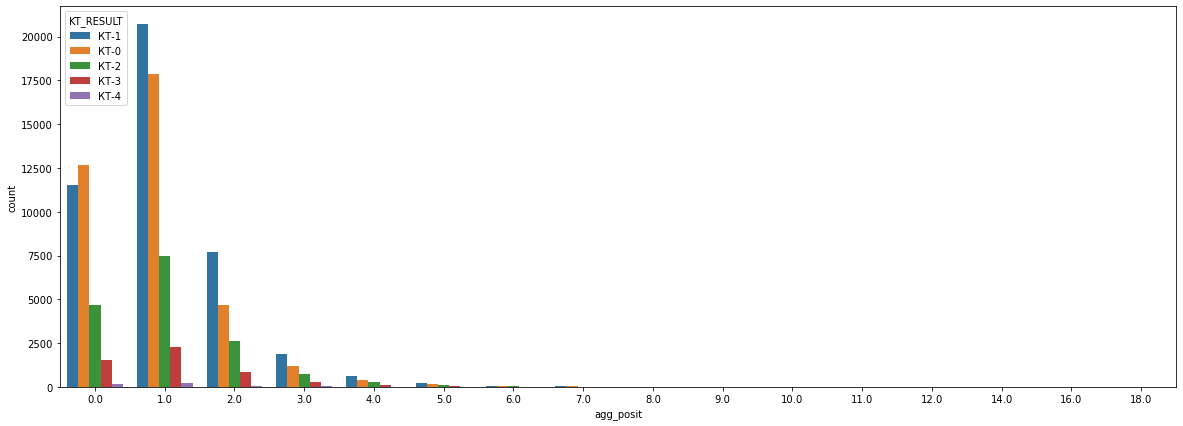

In [37]:
plt.figure(figsize=(20, 7))
sns.countplot(x='agg_posit', data=df_train, hue='KT_RESULT')

<AxesSubplot:xlabel='Одышка', ylabel='count'>

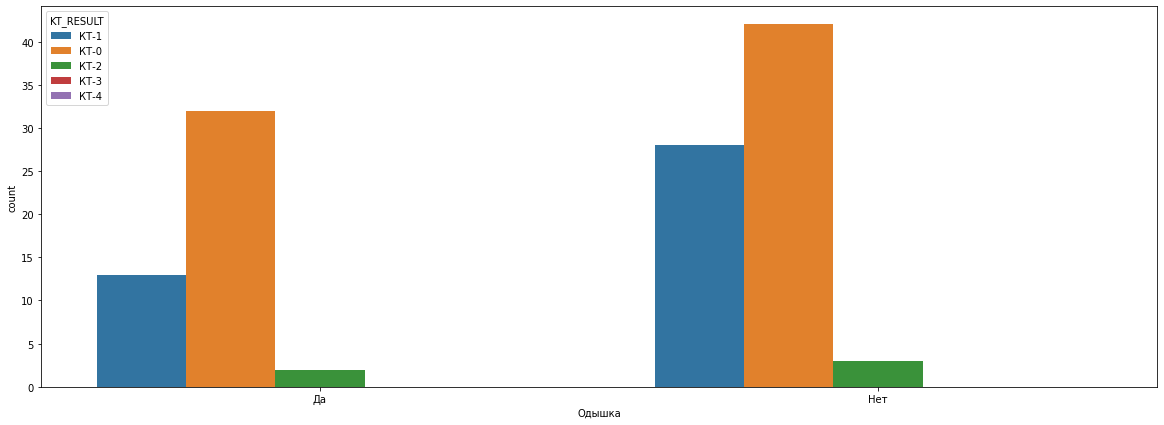

In [38]:
plt.figure(figsize=(20, 7))
sns.countplot(x='Одышка', data=df_train, hue='KT_RESULT')

<AxesSubplot:xlabel='Слабость', ylabel='count'>

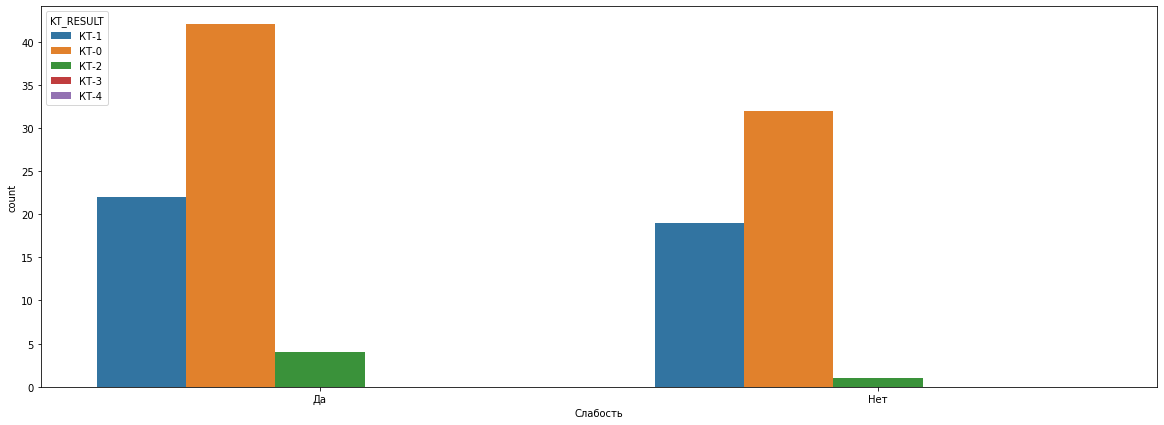

In [39]:
plt.figure(figsize=(20, 7))
sns.countplot(x='Слабость', data=df_train, hue='KT_RESULT')

### Данные опросника как-то не очень информативны оказались + по значимым вопросам их очень мало

In [40]:
df_train = df_train.reset_index()
df_train

,index,idx,DATE,KT_RESULT,DIAGNOSIS,RECIPE,pd_id,person_id,ds_id,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель,gender,birth_dt,age,age_group,DATE_before,KT_max
0,0,301478,2020-04-17,КТ-1,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1970-09-02,51,30-55,2020-04-16,NaN
1,1,327426,2020-04-17,КТ-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1953-01-09,69,55-70,2020-04-16,NaN
2,5,623270,2020-04-17,КТ-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1958-05-12,63,55-70,2020-04-16,NaN
3,6,18024,2020-04-17,КТ-0,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1957-04-06,65,55-70,2020-04-16,NaN
4,7,191578,2020-04-17,КТ-1,J06.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1953-04-13,68,55-70,2020-04-16,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132666,165843,832731,2020-07-12,КТ-1,J12.8,NaN,3234309.0,3155745.0,3416929.0,Z20.8,Контакт с больным и возможность заражения друг...,2020-06-12,Мазок/отделяемое из носоглотки и ротоглотки,2020-06-12,2020-06-12,2020-06-14,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1982-02-13,40,30-55,2020-07-11,0.0
132667,165844,93692,2020-07-12,КТ-0,NaN,Азитромицин/Азитромицин капс. 500 мг по 1 капс...,1842929.0,1737667.0,1951937.0,J18.9,Пневмония неуточненная,2020-05-20,"Кровь, цельная (сыворотка)",2020-05-21,2020-05-21,2020-05-22,83.73,5.23,NaN,Городская поликлиника,ОБНАРУЖЕНО,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1973-07-31,48,30-55,2020-07-11,1.0
132668,165845,83874,2020-07-12,КТ-0,J12.8,Рецепт 00Д4510276184: Amoxicillinum+Acidum Cla...,1963565.0,1857753.0,2079445.0,J18.9,Пневмония неуточненная,2020-04-27,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-22,2020-05-23,2020-05-25,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1965-08-31,56,55-70,2020-07-11,1.0
132669,165846,832754,2020-07-12,КТ-0,J12.8,Рецепт 00Д4510266702: Azithromycinum - Применя...,2463554.0,2359332.0,2601123.0,J06.9,Острая инфекция верхних дыхательных путей неут...,2020-04-30,Мазок/отделяемое из носоглотки и ротоглотки,2020-05-30,2020-05-31,2020-06-01,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1959-01-20,63,55-70,2020-07-11,2.0


In [ ]:
df_train.to_csv('all_data.csv', index=False)

In [41]:
df_test

,idx,DATE,KT_RESULT,DIAGNOSIS,RECIPE,pd_id,person_id,ds_id,mkb10_code,mkb10_name,dis_date,samples_type_id,get_date_at,receive_date_at,result_date_at,IgG,IgM,samples_result_id,mu_type,status,posit,agg_posit,Был ли контакт с пациентом больным Covid 19,Был ли подтверждённый случай заболевания Covid 19,Были ли симптомы ОРВИ на протяжении последних 5 месяцев,Были ли симптомы ковид в последние 5 месяцев?,Одышка,Повышение температуры,Потеря чувства обоняния,Слабость,Сухой кашель,gender,birth_dt,age,age_group,DATE_before,KT_max
2,644661,2020-04-17,NaN,J02.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,М,1956-09-14,65,55-70,2020-04-16,NaN
3,435395,2020-04-17,NaN,J18.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1965-08-28,56,55-70,2020-04-16,NaN
4,365812,2020-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1955-06-18,66,55-70,2020-04-16,NaN
73,468758,2020-04-18,NaN,J04.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1982-06-06,39,30-55,2020-04-17,NaN
295,713933,2020-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1984-03-17,38,30-55,2020-04-17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165784,443576,2020-07-11,NaN,I25.2,NaN,4102607.0,4056259.0,4342463.0,Z11.5,Специальное скрининговое обследование с целью ...,2020-06-29,"Кровь, цельная (сыворотка)",2020-06-30,2020-06-30,2020-06-30,122.21,2.11,NaN,Городская больница,ОБНАРУЖЕНО,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1960-01-15,62,55-70,2020-07-10,NaN
165821,1119183,2020-07-11,NaN,J12.8,Рецепт 00Д4510808713: Amoxicillinum+Acidum Cla...,3626304.0,3565493.0,3838640.0,U07.2,"Коронавирусная инфекция, вызванная вирусом COV...",2020-06-08,Мазок/отделяемое из носоглотки и ротоглотки,2020-06-19,2020-06-19,2020-06-20,NaN,NaN,Не обнаружено,Городская поликлиника,Не обнаружено,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1977-05-30,44,30-55,2020-07-10,NaN
165822,716303,2020-07-11,NaN,E10.7,NaN,867861.0,779556.0,914277.0,Z11.5,Специальное скрининговое обследование с целью ...,2020-04-11,Мазок/отделяемое из носоглотки и ротоглотки,2020-04-30,2020-04-30,2020-05-01,NaN,NaN,Не обнаружено,Городская больница,Не обнаружено,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ж,1992-08-11,29,18-30,2020-07-10,NaN
165823,320050,2020-07-11,NaN,J12.9,NaN,2927439.0,2831542.0,3085532.0,Z11.5,Специальное скрининговое обследование с целью ...,2020-06-07,"Кровь, цельная (сыворотка)",2020-06-07,2020-06-08,2020-06-08,0.12,0.22,NaN,Городская поликлиника,ОБНАРУЖЕНО,1.0,1.0,Да,Нет,Нет,Нет,NaN,NaN,NaN,NaN,NaN,М,1992-11-19,29,18-30,2020-07-10,NaN
